In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import log_loss, roc_auc_score, brier_score_loss, make_scorer, classification_report

from mplsoccer import Pitch
from matplotlib.colors import LinearSegmentedColormap

RANDOM_STATE = 42

In [2]:
n_samples = 10000  # количество ударов

# Ограничиваю удары

x = np.random.normal(loc=85, scale=5, size=n_samples)
x = np.clip(x, 50, 98)  # ограничим минимальное значение до 50, чтобы не было ударов далеко от ворот

y = np.random.normal(loc=50, scale=7, size=n_samples)
y = np.clip(y, 10, 90)  # ограничим, чтобы удары не были слишком под острым углом

In [3]:
# Расстояние до центра ворот (ворота в точке x=100, y=50) (Евклидово расстояние)
distance_to_goal = np.sqrt((100 - x)**2 + (50 - y)**2)

# Базовая вероятность гола экспоненциально убывает с расстоянием
base_prob = np.exp(-distance_to_goal / 10) # если уменьшать, то метрики улучшаться. Но логика будет теряться

# Другие бинарные признаки (0 или 1), распределение вероятностей задаю условно
is_first_touch = np.random.choice([0, 1], size=n_samples, p=[0.7, 0.3])
is_big_chance = np.random.choice([0, 1], size=n_samples, p=[0.9, 0.1])

# Итоговая вероятность с поправками по признакам
final_prob = base_prob + 0.1 * is_first_touch + 0.2 * is_big_chance
final_prob = np.clip(final_prob, 0, 1)  # вероятность в диапазоне [0, 1]
final_prob[distance_to_goal > 60] = 0
# Генерируем целевую переменную (гол или нет) по распределению Бернулли
is_goal = np.random.binomial(1, final_prob)

# Другие бинарные признаки (задаю условно)
# Тайм и зона
period = np.random.choice(['FirstHalf', 'SecondHalf'], size=n_samples, p=[0.4, 0.6])
zone = np.random.choice(['Center', 'Left', 'Right'], size=n_samples, p=[0.6, 0.2, 0.2])

# Assisted и IndividualPlay — противоположные
assisted = np.random.choice([0, 1], size=n_samples, p=[0.5, 0.5])
individual_play = 1 - assisted

# Тип удара (взаимоисключающие)
shot_type = np.random.choice(['LeftFoot', 'RightFoot', 'Head', 'OtherBodyPart'], size=n_samples, p=[0.45, 0.45, 0.08, 0.02])
left_foot = (shot_type == 'LeftFoot').astype(int)
right_foot = (shot_type == 'RightFoot').astype(int)
head = (shot_type == 'Head').astype(int)
other_body_part = (shot_type == 'OtherBodyPart').astype(int)

# FirstTouch и BigChance
first_touch = is_first_touch
big_chance = is_big_chance

# Тип стандарта
set_piece_type = np.random.choice(
    ['None', 'Penalty', 'DirectFreekick', 'Corner', 'Throwin'], 
    size=n_samples, 
    p=[0.9, 0.03, 0.03, 0.03, 0.01]
)
penalty = (set_piece_type == 'Penalty').astype(int)
direct_freekick = (set_piece_type == 'DirectFreekick').astype(int)
from_corner = (set_piece_type == 'Corner').astype(int)
throwin_setpiece = (set_piece_type == 'Throwin').astype(int)
set_piece = (set_piece_type != 'None').astype(int)

# FastBreak и RegularPlay
regular_play = np.random.choice([0, 1], size=n_samples, p=[0.2, 0.8])
fast_break = ((set_piece == 0) & (regular_play == 0)).astype(int)

# Другие признаки
own_goal = np.zeros(n_samples, dtype=int)
volley = (
    (penalty == 0) &
    (direct_freekick == 0) &
    ((left_foot == 1) | (right_foot == 1)) &
    (np.random.rand(n_samples) < 0.02)
).astype(int)

one_on_one = (
    (penalty == 0) &
    (direct_freekick == 0) &
    (first_touch == 0) &
    (from_corner == 0) &
    ((left_foot == 1) | (right_foot == 1)) &
    (np.random.rand(n_samples) < 0.02)
).astype(int)

key_pass = (
    (assisted == 1) &
    (np.random.rand(n_samples) < 0.15)
).astype(int)

# Собираем все в DataFrame
df = pd.DataFrame({
    'x': x,
    'y': y,
    'is_goal': is_goal,
    'period': period,
    'assisted': assisted,
    'zone': zone,
    'individual_play': individual_play,
    'regular_play': regular_play,
    'left_foot': left_foot,
    'right_foot': right_foot,
    'from_corner': from_corner,
    'first_touch': first_touch,
    'head': head,
    'big_chance': big_chance,
    'set_piece': set_piece,
    'volley': volley,
    'fast_break': fast_break,
    'throwin_setpiece': throwin_setpiece,
    'penalty': penalty,
    'one_on_one': one_on_one,
    'key_pass': key_pass,
    'direct_freekick': direct_freekick,
    'own_goal': own_goal,
    'other_body_part': other_body_part,
})

df.head()

,x,y,is_goal,period,assisted,zone,individual_play,regular_play,left_foot,right_foot,...,set_piece,volley,fast_break,throwin_setpiece,penalty,one_on_one,key_pass,direct_freekick,own_goal,other_body_part
0,95.218444,52.471093,1,FirstHalf,0,Left,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,90.504403,53.448580,1,SecondHalf,1,Left,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
2,90.909940,57.873444,1,SecondHalf,0,Center,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,76.714875,45.798506,0,FirstHalf,0,Center,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,85.340462,47.731875,1,FirstHalf,1,Right,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df['is_goal'].value_counts()

is_goal
0    7390
1    2610
Name: count, dtype: int64

# Исследовательский анализ и Предобработка

In [5]:
df.shape

(10000, 24)

In [6]:
display(df.x.max())
display(df.x.min())


98.0

67.60812037938095

In [7]:
display(df.y.max())
display(df.y.min())

76.55362945860307

27.39665797938263

In [8]:
df.columns

Index(['x', 'y', 'is_goal', 'period', 'assisted', 'zone', 'individual_play',
       'regular_play', 'left_foot', 'right_foot', 'from_corner', 'first_touch',
       'head', 'big_chance', 'set_piece', 'volley', 'fast_break',
       'throwin_setpiece', 'penalty', 'one_on_one', 'key_pass',
       'direct_freekick', 'own_goal', 'other_body_part'],
      dtype='object')

In [9]:
distance_to_goal

array([ 5.38233932, 10.10242877, 12.0258185 , ..., 13.23789763,
       10.76804767, 16.8716449 ])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   x                 10000 non-null  float64
 1   y                 10000 non-null  float64
 2   is_goal           10000 non-null  int32  
 3   period            10000 non-null  object 
 4   assisted          10000 non-null  int32  
 5   zone              10000 non-null  object 
 6   individual_play   10000 non-null  int32  
 7   regular_play      10000 non-null  int32  
 8   left_foot         10000 non-null  int32  
 9   right_foot        10000 non-null  int32  
 10  from_corner       10000 non-null  int32  
 11  first_touch       10000 non-null  int32  
 12  head              10000 non-null  int32  
 13  big_chance        10000 non-null  int32  
 14  set_piece         10000 non-null  int32  
 15  volley            10000 non-null  int32  
 16  fast_break        10000 non-null  int32  

In [11]:
# Удаляем столбец с автоголами
df.drop('own_goal', axis=1, inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   x                 10000 non-null  float64
 1   y                 10000 non-null  float64
 2   is_goal           10000 non-null  int32  
 3   period            10000 non-null  object 
 4   assisted          10000 non-null  int32  
 5   zone              10000 non-null  object 
 6   individual_play   10000 non-null  int32  
 7   regular_play      10000 non-null  int32  
 8   left_foot         10000 non-null  int32  
 9   right_foot        10000 non-null  int32  
 10  from_corner       10000 non-null  int32  
 11  first_touch       10000 non-null  int32  
 12  head              10000 non-null  int32  
 13  big_chance        10000 non-null  int32  
 14  set_piece         10000 non-null  int32  
 15  volley            10000 non-null  int32  
 16  fast_break        10000 non-null  int32  

In [13]:
df.is_goal.value_counts()

is_goal
0    7390
1    2610
Name: count, dtype: int64

In [14]:
df.period.value_counts()

period
SecondHalf    5991
FirstHalf     4009
Name: count, dtype: int64

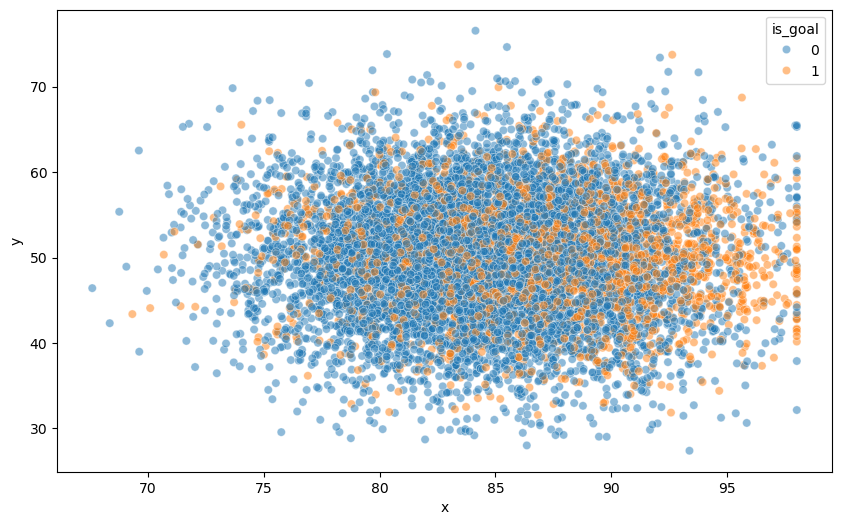

In [15]:
# Распределение ударов

plt.figure(figsize=(10, 6))

sns.scatterplot(x='x', y='y', data=df, hue='is_goal', alpha=0.5);

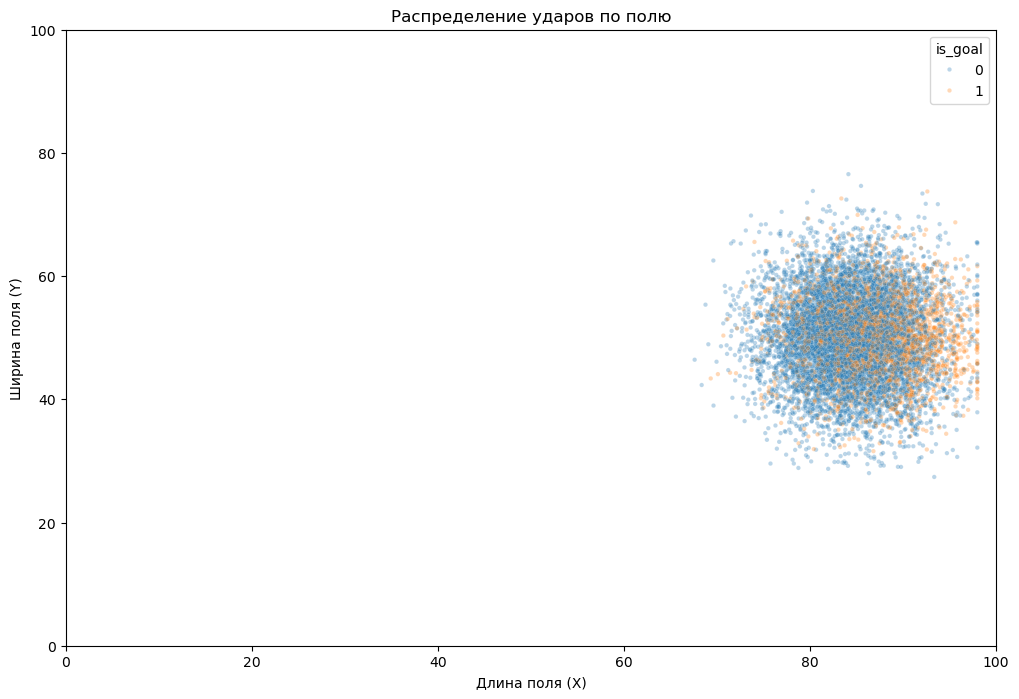

In [16]:
# Визуализация в натуральном масштабе
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='x', y='y', alpha=0.3, s=10, hue='is_goal')
plt.title('Распределение ударов по полю')
plt.xlabel('Длина поля (X)')
plt.ylabel('Ширина поля (Y)')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.show()

In [17]:
goal_x, goal_y = 100, 50
# Расстояние до ворот - Евклидово расстояние до ворот
df['shot_distance'] = np.sqrt((df['x'] - goal_x)**2 + (df['y'] - goal_y)**2)

In [18]:
# Описательная статистика
df['shot_distance'].describe()

count    10000.000000
mean        16.520334
std          4.910977
min          2.084831
25%         13.190775
50%         16.518457
75%         19.832572
max         32.968269
Name: shot_distance, dtype: float64

- Средняя дистанция - 16.6 метров от ворот;
- Максимальная - 35.5 метров;
- Минимальная - 2 метра.

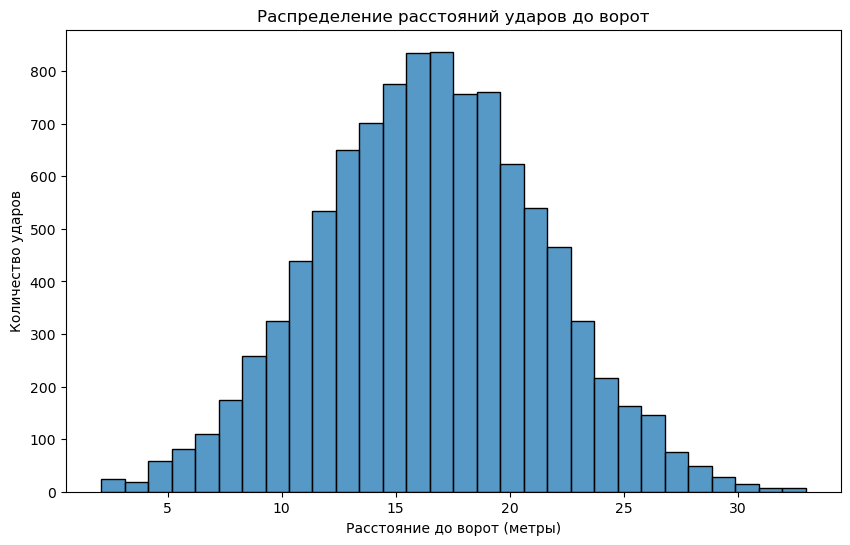

In [19]:
# Распределение ударов на гистограмме
plt.figure(figsize=(10, 6))
sns.histplot(df['shot_distance'], bins=30, kde=False)
plt.title('Распределение расстояний ударов до ворот')
plt.xlabel('Расстояние до ворот (метры)')
plt.ylabel('Количество ударов')
plt.show()

# Построение модели Логистической регрессии

In [20]:
X = df.drop(['is_goal', 'period'], axis=1) # Также удалю признак 'period' - гипотеза о том, что тайм не влияет на вероятность забить гол
y = df['is_goal']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state = RANDOM_STATE
)

# выполняем кодирование категориальных признаков
# переменная с экземпляром класса OneHotEncoder()
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

# обучение и преобразование категориальных признаков тренировочной выборки
X_train_ohe = encoder.fit_transform(X_train[['zone']])

# преобразование категориальных признаков тестовой выборки
X_test_ohe = encoder.transform(X_test[['zone']])

# получаем список новых столбцов
encoder_col_names = encoder.get_feature_names_out()

# создаём тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names, index=X_train.index)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names, index=X_test.index)

# удаляем 'zone' из оригинальных данных
X_train = X_train.drop('zone', axis=1)
X_test = X_test.drop('zone', axis=1)

# объединяем числовые признаки и OHE-кодированные
X_train = pd.concat([X_train, X_train_ohe], axis=1)
X_test = pd.concat([X_test, X_test_ohe], axis=1) 

# инициализация модели
clf = LogisticRegression(max_iter=1000)

# обучение модели на тренировочных данных
clf = clf.fit(X_train, y_train)

# получаем предсказания модели на тестовых данных
y_pred = clf.predict(X_test)

In [21]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [22]:
predictions = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred
}, index=X_test.index)

In [23]:
# Предсказания модели
predictions['y_pred'].value_counts()

y_pred
0    1869
1     131
Name: count, dtype: int64

In [24]:
y_pred_proba = clf.predict_proba(X_test)[:, 1]

In [25]:
# Рассчитанные вероятности забить гол
y_pred_proba[0:5]

array([0.11559199, 0.28159847, 0.25791885, 0.45406028, 0.18248972])

In [26]:
# Добавим вероятности к исходному датасету
final_df = X_test.copy()
final_df['goal_probability'] = y_pred_proba

In [27]:
# Посмотрим любую строчку датасета
final_df.iloc[497]

x                   81.599747
y                   46.942534
assisted             0.000000
individual_play      1.000000
regular_play         0.000000
left_foot            0.000000
right_foot           1.000000
from_corner          0.000000
first_touch          0.000000
head                 0.000000
big_chance           0.000000
set_piece            0.000000
volley               0.000000
fast_break           1.000000
throwin_setpiece     0.000000
penalty              0.000000
one_on_one           0.000000
key_pass             0.000000
direct_freekick      0.000000
other_body_part      0.000000
shot_distance       18.652544
zone_Left            1.000000
zone_Right           0.000000
goal_probability     0.170084
Name: 2522, dtype: float64

In [28]:
# Сортировка по убыванию Xg
final_df.sort_values(by='goal_probability', ascending=False).head()

,x,y,assisted,individual_play,regular_play,left_foot,right_foot,from_corner,first_touch,head,...,throwin_setpiece,penalty,one_on_one,key_pass,direct_freekick,other_body_part,shot_distance,zone_Left,zone_Right,goal_probability
2465,93.967633,50.689650,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,6.071661,0.0,0.0,0.785866
7204,93.754455,50.724015,1,0,1,1,0,0,1,0,...,0,0,0,0,0,0,6.287370,0.0,0.0,0.780004
9783,98.000000,48.312615,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,2.616728,0.0,0.0,0.777002
637,92.956714,55.241914,1,0,1,0,1,0,1,0,...,0,0,0,0,0,0,8.779837,1.0,0.0,0.747616
7415,98.000000,53.617327,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,4.133407,0.0,0.0,0.747277


In [29]:
# Оценка качества модели
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC: {roc_auc}")

ROC AUC: 0.6884687405617638


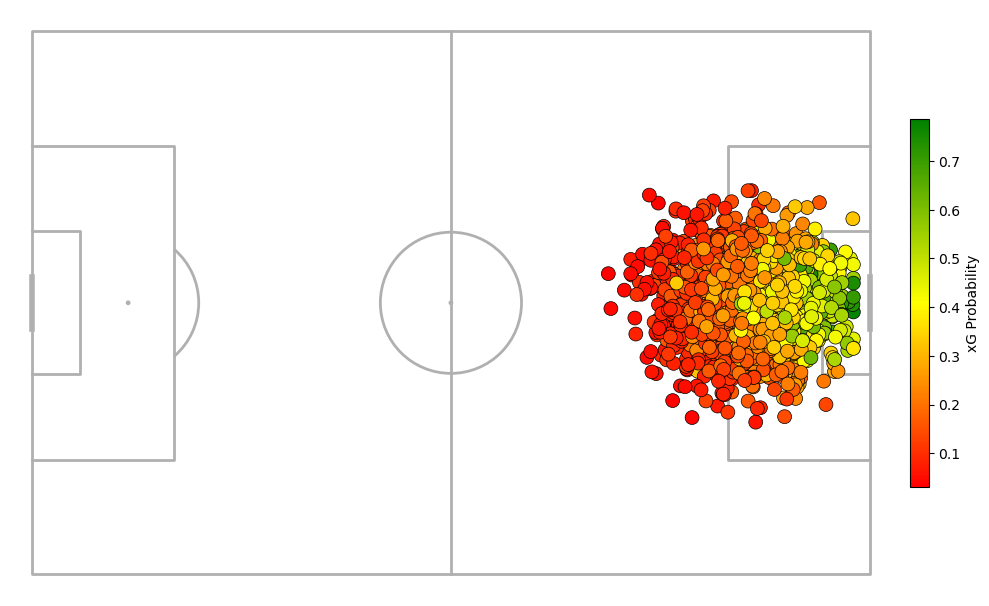

In [30]:
# Построение xG shot map
pitch = Pitch(pitch_type='opta')

# Цвета
colors = ['red', 'yellow', 'green']

# Пользовательские настройки
cmap = LinearSegmentedColormap.from_list('my_colormap', colors)

fig, ax = pitch.draw(figsize=(10, 8))

# Диаграмма рассеяния
sc = pitch.scatter(
    final_df['x'], 
    final_df['y'],  
    c=final_df['goal_probability'],  # xG по цветам
    cmap=cmap,  # красный-зеленый градиент
    edgecolors='black', linewidth=0.5, s=100,  # стиль точки
    ax=ax
)

# Легенда для xG
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', fraction=0.02, pad=0.02)
cbar.set_label('xG Probability')

Можно увидеть, как удары с более высоким xG формируют "дугу" на границах штрафной площади. То есть вероятность забить гол в этой зоне увеличивается.

In [31]:
# Можно попробовать еще подобрать гиперпараметры
param_grid = [
    {
        'C': [1, 2, 3, 4],  # range(1, 5) → [1, 2, 3, 4]
        'penalty': ['l1'],
        'solver': ['liblinear']
    }
]

# Инициализация модели
logreg = LogisticRegression(random_state=RANDOM_STATE)

# GridSearchCV - смотрим все возможные варианты
grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    refit=True  # автоматически переобучает лучшую модель
)

# Обучение
grid_search.fit(X_train, y_train)

# Вывод результатов
print('Лучшая модель:\n', grid_search.best_estimator_)
print('ROC-AUC (тренировочная):', grid_search.best_score_)

# Предсказание вероятностей для теста
y_test_proba = grid_search.predict_proba(X_test)[:, 1]  # берём вероятности класса 1
test_roc_auc = roc_auc_score(y_test, y_test_proba)

print(f'ROC-AUC (тестовая): {test_roc_auc:.4f}')

Лучшая модель:
 LogisticRegression(C=1, penalty='l1', random_state=42, solver='liblinear')
ROC-AUC (тренировочная): 0.688277083822918
ROC-AUC (тестовая): 0.6891


In [32]:
final_df.head()

,x,y,assisted,individual_play,regular_play,left_foot,right_foot,from_corner,first_touch,head,...,throwin_setpiece,penalty,one_on_one,key_pass,direct_freekick,other_body_part,shot_distance,zone_Left,zone_Right,goal_probability
6252,80.741400,60.254191,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,21.818389,0.0,0.0,0.115592
4684,86.485572,52.557866,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,13.754361,1.0,0.0,0.281598
1731,84.253641,39.835246,1,0,1,0,1,0,1,0,...,0,0,0,1,0,0,18.742199,0.0,0.0,0.257919
4742,86.433260,53.652244,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,14.049745,0.0,0.0,0.454060
4521,82.299811,52.990324,0,1,1,1,0,0,0,0,...,0,1,0,0,0,0,17.951009,0.0,0.0,0.182490


# Вывод
В данном проекте была построена модель прогнозирования вероятности гола (xG) на основе синтетически сгенерированных данных.
- Модель показывает удовлетворительную способность различать удары с последующим голом и без (ROC AUC ≈ 0.69), что выше случайного угадывания, хотя, конечно, нужно улучшать метрику.

Данные - синтетические и упрощённые, поэтому метрики не достигают идеальных значений. Но цель проекта была показать:
- Умение синтезировать и структурировать футбольные данные;
- Навыки подготовки и кодирования признаков;
- Применение классических ML моделей и метрик качества.